In [1]:
import tensorflow as tf
import keras_preprocessing
print(tf.__version__)
print(keras_preprocessing.__version__)

2.9.3
1.1.2


In [2]:
import tensorflow as tf

# Verificar se a GPU está disponível
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Criar um tensor simples
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
    c = tf.matmul(a, b)

print(c)


Num GPUs Available:  1
tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


In [1]:

import tensorflow as tf
import keras_preprocessing
from tensorflow.keras.preprocessing.image import load_img
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
tf.config.run_functions_eagerly(True)
df = pd.read_csv("train.csv", index_col=0)
print(df.shape)
df.head()


train_set, valid_set = train_test_split(df, test_size=0.2, random_state=42)

print(train_set.shape)
print(valid_set.shape)
SOURCE = 'images/train'
VALID_DIR = 'temp/valid/'
TRAIN_DIR = 'temp/train/'

(1821, 4)
(1456, 4)
(365, 4)


In [4]:

import os
import shutil

# Mudar o diretório de trabalho
os.chdir('e:/gitHub2/IA-deeplearning/plant-pathology')

# Deletar o diretório temporário, se existir
if os.path.exists('temp'):
    shutil.rmtree('temp')

# Criar o diretório temporário
os.mkdir('temp')

# Criar subdiretórios para treinamento
os.mkdir('temp/train')
os.mkdir('temp/train/healthy')
os.mkdir('temp/train/multiple_diseases')
os.mkdir('temp/train/rust')
os.mkdir('temp/train/scab')

# Criar subdiretórios para validação
os.mkdir('temp/valid')
os.mkdir('temp/valid/healthy')
os.mkdir('temp/valid/multiple_diseases')
os.mkdir('temp/valid/rust')
os.mkdir('temp/valid/scab')

In [5]:
# copy images to train directory
from shutil import copyfile

# copy images to valid directory
for index, data in valid_set.iterrows():
    label = df.columns[np.argmax(data)]
    filepath = os.path.join(SOURCE, index + ".jpg")
    destination = os.path.join(VALID_DIR, label, index + ".jpg")
    copyfile(filepath, destination)
    
for subdir in os.listdir(VALID_DIR):
    print(subdir, len(os.listdir(os.path.join(VALID_DIR, subdir))))


# copy images to train directory
for index, data in train_set.iterrows():
    label = df.columns[np.argmax(data)]
    filepath = os.path.join(SOURCE, index + ".jpg")
    destination = os.path.join(TRAIN_DIR, label, index + ".jpg")
    copyfile(filepath, destination)
    
for subdir in os.listdir(TRAIN_DIR):
    print(subdir, len(os.listdir(os.path.join(TRAIN_DIR, subdir))))

healthy_dir = os.path.join(TRAIN_DIR, 'healthy')
mdiseases_dir = os.path.join(TRAIN_DIR, 'multiple_diseases')
scab_dir = os.path.join(TRAIN_DIR, 'scab')
rust_dir = os.path.join(TRAIN_DIR, 'rust')

healthy_files = os.listdir(healthy_dir)
mdiseases_files = os.listdir(mdiseases_dir)
scab_files = os.listdir(scab_dir)
rust_files = os.listdir(rust_dir) 


healthy 100
multiple_diseases 18
rust 120
scab 127
healthy 416
multiple_diseases 73
rust 502
scab 465


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SOURCE = 'images/train'
VALID_DIR = 'temp/valid/'
TRAIN_DIR = 'temp/train/'

training_datagen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_directory(TRAIN_DIR, target_size=(225, 150), class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(VALID_DIR, target_size=(225, 150), class_mode='categorical')

model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(225, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()



Found 1456 images belonging to 4 classes.
Found 365 images belonging to 4 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 74, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 72, 64)       36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 34, 128)       73856     
                                       

In [4]:
# Compilar o modelo

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'], run_eagerly=True)

# Callbacks
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=7)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("checkpointsavebest.keras", save_best_only=True)
# checkpoint_loss = tf.keras.callbacks.ModelCheckpoint('checkpoint_Val_Loss.keras', save_best_only=True, monitor='val_loss', mode='min')
checkpoint_accuracy = tf.keras.callbacks.ModelCheckpoint('checkpoint_val_accuracy.keras', save_best_only=True, monitor='val_accuracy', mode='max')



# Calcular steps_per_epoch e validation_steps
batch_size = 31
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("nome da gpu", tf.test.gpu_device_name())
print(tf.test.is_gpu_available())
print("steps_per_epoch", steps_per_epoch)
print("validation_steps", validation_steps)

print(TRAIN_DIR, VALID_DIR)
# Verificar se os generators têm pelo menos um lote de dados
if train_generator is not None and validation_generator is not None:
    if len(train_generator) > 0 and len(validation_generator) > 0:
        # forçar a execução na gpu
        with tf.device('/device:GPU:0'):
            history = model.fit(
                train_generator,
                epochs=50,
                steps_per_epoch=steps_per_epoch,
                validation_data=validation_generator,
                validation_steps=validation_steps,
                callbacks=[early_stopping_cb,checkpoint_cb,checkpoint_accuracy],
                verbose=1
            )
    else:
        print("Error: The generators do not have any data.")
else:
    print("Error: One of the generators is None.")


Num GPUs Available:  1
nome da gpu /device:GPU:0
True
steps_per_epoch 46
validation_steps 11
temp/train/ temp/valid/
Epoch 1/50


c:\Users\berna\anaconda3\envs\tf2\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


46/46 [==============================] - 67s 1s/step - loss: 1.4487 - accuracy: 0.3104 - val_loss: 1.4489 - val_accuracy: 0.3352
Epoch 2/50
46/46 [==============================] - 56s 1s/step - loss: 1.2670 - accuracy: 0.3468 - val_loss: 1.5527 - val_accuracy: 0.2699
Epoch 3/50
46/46 [==============================] - 54s 1s/step - loss: 1.2624 - accuracy: 0.3771 - val_loss: 1.1667 - val_accuracy: 0.4858
Epoch 4/50
46/46 [==============================] - 54s 1s/step - loss: 1.2123 - accuracy: 0.4059 - val_loss: 1.1663 - val_accuracy: 0.3920
Epoch 5/50
46/46 [==============================] - 56s 1s/step - loss: 1.2006 - accuracy: 0.4766 - val_loss: 1.0080 - val_accuracy: 0.5795
Epoch 6/50
46/46 [==============================] - 57s 1s/step - loss: 1.0138 - accuracy: 0.5955 - val_loss: 0.9844 - val_accuracy: 0.5994
Epoch 7/50
46/46 [==============================] - 57s 1s/step - loss: 0.9262 - accuracy: 0.6360 - val_loss: 0.7582 - val_accuracy: 0.6392
Epoch 8/50
46/46 [=============

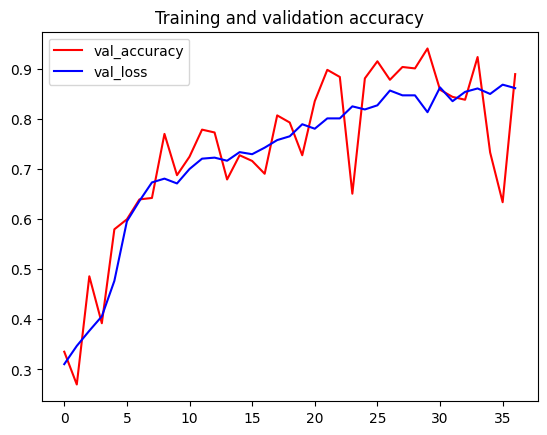

In [5]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, val_acc, 'r', label='val_accuracy')
plt.plot(epochs, acc, 'b', label='val_loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

In [12]:
! conda list

# packages in environment at C:\Users\berna\anaconda3\envs\tf2:
#
# Name                    Version                   Build  Channel
absl-py                   2.1.0                    pypi_0    pypi
asgiref                   3.8.1                    pypi_0    pypi
asttokens                 2.4.1                    pypi_0    pypi
astunparse                1.6.3                    pypi_0    pypi
blas                      1.0                         mkl  
bottleneck                1.3.7            py39h9128911_0  
ca-certificates           2024.7.4             h56e8100_0    conda-forge
cachetools                5.5.0                    pypi_0    pypi
certifi                   2024.7.4                 pypi_0    pypi
charset-normalizer        3.3.2                    pypi_0    pypi
colorama                  0.4.6                    pypi_0    pypi
comm                      0.2.2                    pypi_0    pypi
contourpy                 1.3.0                    pypi_0    pypi
cudatoolkit   